In [1]:

# !pip3 install -U lightautoml

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
# !pip3 install -U pandas

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

import torch

from category_encoders import WOEEncoder

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Downloading data**

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
addition_data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

train_df['is_generated'] = 1
test_df['is_generated'] = 1
addition_data['is_generated'] = 0

In [3]:
train_df = train_df.drop(527).drop(1398).reset_index(drop=True)

In [4]:
train_df = train_df.drop('id', axis=1)
train_df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,is_generated
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,1,10,2,3,10,0,7,8,0,1
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,1,4,3,3,4,2,0,3,0,1
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,2,4,3,3,3,2,1,2,0,1
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,0,15,1,1,6,0,0,2,0,1
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,0,31,0,3,31,14,4,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,30,Travel_Rarely,945,Sales,1,3,Life Sciences,1,4,Female,...,0,10,2,4,10,0,0,8,0,1
1671,32,Travel_Rarely,1303,Research & Development,2,3,Life Sciences,1,1,Male,...,1,10,3,4,4,2,1,3,0,1
1672,29,Travel_Frequently,1184,Human Resources,24,3,Human Resources,1,2,Male,...,0,1,2,3,1,0,0,0,1,1
1673,36,Travel_Rarely,441,Sales,9,2,Marketing,1,2,Male,...,2,10,3,2,10,3,0,8,0,1


<AxesSubplot:>

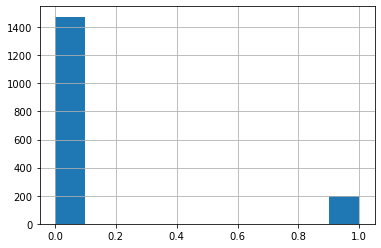

In [5]:
train_df.Attrition.hist()

In [6]:
train_df.isna().any()

Age                         False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesLastYear       False
WorkLifeBalance             False
YearsAtCompany

In [7]:
addition_data['Attrition'] = (addition_data['Attrition'] == 'Yes').astype(int)
# addition_data = addition_data[addition_data.Attrition == 1]
addition_data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_generated
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,0
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,0
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,80,0,7,3,3,0,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,80,1,17,3,3,5,2,0,3,0
1466,39,0,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,80,1,9,5,3,7,7,1,7,0
1467,27,0,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,80,1,6,0,3,6,2,0,3,0
1468,49,0,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,80,0,17,3,2,9,6,0,8,0


<AxesSubplot:>

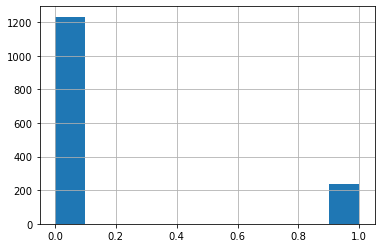

In [8]:
addition_data.Attrition.hist()

In [9]:
addition_data.isna().any()

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

In [10]:
train_df = pd.concat([train_df, addition_data],axis=0, ignore_index=True)
train_df = train_df.drop('EmployeeNumber', axis=1)
train_df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,is_generated
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,1,10,2,3,10,0,7,8,0,1
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,1,4,3,3,4,2,0,3,0,1
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,2,4,3,3,3,2,1,2,0,1
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,0,15,1,1,6,0,0,2,0,1
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,0,31,0,3,31,14,4,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3140,36,Travel_Frequently,884,Research & Development,23,2,Medical,1,3,Male,...,1,17,3,3,5,2,0,3,0,0
3141,39,Travel_Rarely,613,Research & Development,6,1,Medical,1,4,Male,...,1,9,5,3,7,7,1,7,0,0
3142,27,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2,Male,...,1,6,0,3,6,2,0,3,0,0
3143,49,Travel_Frequently,1023,Sales,2,3,Medical,1,4,Male,...,0,17,3,2,9,6,0,8,0,0


In [11]:
train_df.isna().any()

Age                         False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesLastYear       False
WorkLifeBalance             False
YearsAtCompany

In [12]:
def is_young(x):
    if x <=25:
        return 1
    else:
        return 0
    
def young_and_low_daily_rate(x):
    if x['Age'] <= 25 & x['DailyRate'] < 500:
        return 1
    else:
        return 0
    
def overtime_satisfaction(x):
        if x['OverTime'] == 'Yes':
            return (x['MonthlyIncome'] * (x['StockOptionLevel'] + 0.05) * x['JobSatisfaction'])/x['Age']
        else:
            return (x['MonthlyIncome'] * (x['StockOptionLevel'] + 1.05) * x['JobSatisfaction'])/x['Age']

In [13]:
df = pd.concat([train_df, test_df], axis=0)
df = df.drop(["EmployeeCount", "Over18", "StandardHours"], axis=1)

df['is_young'] = df['Age'].apply(lambda x: is_young(x))
df['young_and_underpaid'] = df.apply(lambda x: young_and_low_daily_rate(x), axis = 1)
df['worklife_stock'] = df.apply(lambda x: x['WorkLifeBalance'] + x['StockOptionLevel'], axis = 1)

df['income_satisfaction'] = df.apply(lambda x: x['JobSatisfaction'] * x['MonthlyIncome'], axis = 1)
df['income_level_environ_job_sat'] = df.apply(lambda x: x['EnvironmentSatisfaction']*x['JobSatisfaction'] * (x['MonthlyIncome']/x['JobLevel']), axis = 1)
df['overtime_stock'] = df.apply(lambda x: overtime_satisfaction(x), axis = 1)

# df = pd.get_dummies(df)
df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,YearsWithCurrManager,Attrition,is_generated,id,is_young,young_and_underpaid,worklife_stock,income_satisfaction,income_level_environ_job_sat,overtime_stock
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,4,Male,42,...,8,0.0,1,NaN,0,0,4,10384,41536.0,302.866667
1,35,Travel_Rarely,921,Sales,8,3,Other,1,Male,46,...,3,0.0,1,NaN,0,0,4,2899,2899.0,169.798571
2,32,Travel_Rarely,718,Sales,26,3,Marketing,3,Male,80,...,2,0.0,1,NaN,0,0,5,18508,27762.0,1764.043750
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,3,Female,40,...,2,0.0,1,NaN,0,0,1,5347,8020.5,147.746053
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,2,Female,37,...,10,1.0,1,NaN,0,0,3,19033,7613.2,19.033000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,31,Travel_Rarely,755,Sales,1,1,Life Sciences,3,Male,81,...,0,NaN,1,2791.0,0,0,4,18712,56136.0,1237.406452
1115,40,Travel_Rarely,654,Research & Development,26,5,Medical,3,Male,96,...,8,NaN,1,2792.0,0,0,4,24880,37320.0,1275.100000
1116,42,Travel_Frequently,884,Research & Development,1,4,Medical,2,Female,65,...,2,NaN,1,2793.0,0,0,3,5238,5238.0,255.664286
1117,25,Travel_Frequently,1469,Sales,1,2,Technical Degree,3,Male,68,...,3,NaN,1,2794.0,1,1,4,19196,28794.0,1574.072000


In [14]:
features = ['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'is_generated', 'id', 'is_young',
       'young_and_underpaid', 'worklife_stock', 'income_satisfaction',
        'income_level_environ_job_sat', 'overtime_stock']
cat_features = ['BusinessTravel', 'Department','Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
               'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus','NumCompaniesWorked', 'OverTime', 
               'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 
                'WorkLifeBalance', 'YearsAtCompany','is_young', 'young_and_underpaid']

Woe encoder from @faelk8 notebook https://www.kaggle.com/code/faelk8/catboost/notebook

In [15]:
woe = WOEEncoder(drop_invariant=True, randomized = True)
for col in cat_features:
    df[col] = df[col].astype(str)
woe.fit(df[features][:-len(test_df)], df['Attrition'][:-len(test_df)], cols = cat_features)
X = woe.transform(df[features])
X['Attrition'] = df['Attrition']
df = X

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y = df['Attrition']
df = df.drop(['id', 'Attrition'], axis=1)

df[df.columns] = scaler.fit_transform(df[df.columns])

In [17]:
train_df = df.iloc[:-len(test_df),:]
train_df['Attrition'] = y[:-len(test_df)]
test_df = df.iloc[-len(test_df):,:].reset_index(drop=True)

X = train_df.drop('Attrition', axis=1)
y = train_df.Attrition
X_test = test_df

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_21028\1833615342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Attrition'] = y[:-len(test_df)]


**The model**

In [18]:
import torch.nn as nn
import torch.nn.functional as F


In [19]:
task = Task('binary', metric = 'auc')

N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 60 * 60
TARGET_NAME = 'Attrition'

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)
# TabularUtilizedAutoML
# TabularAutoML
automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
#     reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
#     general_params = {"use_algos": [all_models]},
    reader_params = {'n_jobs': N_THREADS}
)

In [20]:
roles = {
    'target': TARGET_NAME
}

In [ ]:
preds_tr = automl.fit_predict(train_df, roles = roles, verbose = 1)

[20:29:56] Start automl utilizator with listed constraints:
[20:29:56] - time: 3600.00 seconds
[20:29:56] - CPU: 4 cores
[20:29:56] - memory: 16 GB

[20:29:56] If one preset completes earlier, next preset configuration will be started

[20:29:56] ==================================================
[20:29:56] Start 0 automl preset configuration:
[20:29:56] C:\Users\Uporabnik\AppData\Roaming\Python\Python39\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[20:29:56] Stdout logging level is INFO.
[20:29:56] Task: binary

[20:29:56] Start automl preset with listed constraints:
[20:29:56] - time: 3600.00 seconds
[20:29:56] - CPU: 4 cores
[20:29:56] - memory: 16 GB

[20:29:56] Train data shape: (3145, 38)

[20:29:59] Layer 1 train process start. Time left 3597.53 secs
[20:29:59] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[20:29:59] Fitting Lvl_0_Pipe_0_M

[20:34:46] Stdout logging level is INFO.
[20:34:46] Task: binary

[20:34:46] Start automl preset with listed constraints:
[20:34:46] - time: 3310.06 seconds
[20:34:46] - CPU: 4 cores
[20:34:46] - memory: 16 GB

[20:34:46] Train data shape: (3145, 38)

[20:34:46] Layer 1 train process start. Time left 3309.94 secs
[20:34:46] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[20:34:47] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8698466109400402
[20:34:47] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[20:34:47] Time left 3309.35 secs

[20:34:47] Selector_LightGBM fitting and predicting completed
[20:34:48] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[20:34:50] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8568315255417459
[20:34:50] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[20:34:50] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[20:36:12] Hyperparameters optimization for Lvl

[20:37:42] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:37:46] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8388417740130946
[20:37:46] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:37:46] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:37:49] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8428471956978053
[20:37:49] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:37:49] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:37:53] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8458935132449323
[20:37:53] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:37:53] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:37:55] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8553349850768466
[20:37:55] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:37:55] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:37:57] Fi

[20:39:00] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8453070654286478
[20:39:00] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:39:00] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:39:03] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8467360038397966
[20:39:03] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:39:03] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:39:06] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8467647347126406
[20:39:06] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:39:06] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:39:08] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8549648638325632
[20:39:08] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:39:08] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:39:11] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.853

[20:40:14] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:40:14] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:40:17] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8494409310154843
[20:40:17] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:40:17] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:40:20] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8555166655963007
[20:40:20] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:40:20] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:40:23] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8561960662364922
[20:40:23] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:40:23] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:40:26] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8537387315826656
[20:40:26] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting complete

[20:41:39] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[20:41:39] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:41:39] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8557853837599587
[20:41:39] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:41:39] Time left 2896.94 secs

[20:41:39] Layer 1 training completed.

[20:41:39] Blending: optimization starts with equal weights and score 0.8658825955132518
[20:41:39] Blending: iteration 0: score = 0.8709789453403594, weights = [0.80363446 0.         0.19636555]
[20:41:39] Blending: iteration 1: score = 0.8709789453403594, weights = [0.80363446 0.         0.19636555]
[20:41:39] Blending: no score update. Terminated

[20:41:39] Automl preset training completed in 264.70 seconds

[20:41:39] Model description:
Final prediction for new objects (level 0) = 
	 0.80363 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.19637 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tu

[20:44:58] Blending: optimization starts with equal weights and score 0.8630602097691729
[20:44:58] Blending: iteration 0: score = 0.8702463080828395, weights = [0.8251022  0.06560498 0.10929285]
[20:44:58] Blending: iteration 1: score = 0.8703451760864495, weights = [0.8537711 0.        0.1462289]
[20:44:58] Blending: iteration 2: score = 0.8703451760864495, weights = [0.8537711 0.        0.1462289]
[20:44:58] Blending: no score update. Terminated

[20:44:58] Automl preset training completed in 77.14 seconds

[20:44:58] Model description:
Final prediction for new objects (level 0) = 
	 0.85377 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.14623 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 

[20:44:58] ==================================================
[20:44:58] Start 2 automl preset configuration:
[20:44:58] C:\Users\Uporabnik\AppData\Roaming\Python\Python39\site-packages\lightautoml\automl\presets\tabular_configs\conf_2_select_mode_1_no_typ.yml, random state: {'

[20:48:01] Blending: no score update. Terminated

[20:48:01] Automl preset training completed in 59.17 seconds

[20:48:01] Model description:
Final prediction for new objects (level 0) = 
	 0.87625 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.06187 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.06187 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 

[20:48:01] ==================================================
[20:48:01] Start 5 automl preset configuration:
[20:48:01] C:\Users\Uporabnik\AppData\Roaming\Python\Python39\site-packages\lightautoml\automl\presets\tabular_configs\conf_5_sel_type_1_tuning_full.yml, random state: {'reader_params': {'random_state': 54}, 'general_params': {'return_all_predictions': False}}
[20:48:01] Stdout logging level is INFO.
[20:48:01] Task: binary

[20:48:01] Start automl preset with listed constraints:
[20:48:01] - time: 2515.30 seconds
[20:48:01] - CPU: 4 cores
[20:48:01] - memory: 16 GB

[20:48:01] Train data shape: (3145, 38

[20:49:19] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8242980371743693
[20:49:19] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:49:19] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:49:21] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8463210962349036
[20:49:21] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:49:21] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:49:23] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8483398625650248
[20:49:23] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:49:23] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:49:25] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8432063316083542
[20:49:25] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:49:25] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:49:27] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.847

[20:50:33] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:50:33] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:50:37] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8451338351659125
[20:50:37] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:50:37] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:50:39] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8442372629280477
[20:50:39] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:50:39] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:50:41] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8513777298554329
[20:50:41] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:50:41] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:50:45] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.816123258824603
[20:50:45] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed

[20:51:40] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:51:42] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8522988078377821
[20:51:42] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:51:42] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:51:44] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8519227714137955
[20:51:44] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:51:44] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:51:48] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8485401336492603
[20:51:48] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:51:48] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:51:50] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8492364348028894
[20:51:50] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:51:50] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:51:51] Fi

[20:52:54] Train data shape: (3145, 38)

[20:52:55] Layer 1 train process start. Time left 2221.84 secs
[20:52:55] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[20:52:55] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8722794398493826
[20:52:55] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[20:52:55] Time left 2221.27 secs

[20:52:55] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[20:52:57] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8479621360896943
[20:52:57] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[20:52:57] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


In [ ]:
preds_tr

In [ ]:
preds = automl.predict(X_test)
preds

**Making submission**

In [ ]:
submission['Attrition'] = preds.data[:,0]
submission

In [ ]:
submission.to_csv('submission.csv', index=False)